# Distribution des naissances dans le temps 

Dans ce carnet est proposée une analyse de la distribution dans le temps des années de naissance de la population retenue, et la mise en évidence de générations.

On met aussi en évidence l'évolution dans le temps des genres

In [1]:
### Librairie à installer dans l'environnement conda
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [4]:
## define SPARQL enpoint
endpoint = "https://query.wikidata.org/sparql"

In [5]:
query = """
SELECT DISTINCT ?item  ?itemLabel  ?gender ?year
        WHERE {
            {
            {?item wdt:P106 wd:Q169470}
          UNION 
          {?item wdt:P106 wd:Q11063}
            UNION
              {?item wdt:P106 wd:Q155647}
              }
          
          ?item wdt:P31 wd:Q5;  # Any instance of a human.
              wdt:P569 ?birthDate;
                wdt:P21 ?gender.
        BIND(REPLACE(str(?birthDate), "(.*)([0-9]{4})(.*)", "$2") AS ?year)
        FILTER(xsd:integer(?year) > 1350 )
          
          SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
        } 
     ORDER BY ?year
"""

In [ ]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [1]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

NameError: name 'spqf' is not defined

In [ ]:
### Créer un DataFrame à partir du résultat
df_r = pd.DataFrame(r)
df_r.columns = ['personUri', 'personLabel', 'genderUri', 'birthYear']
df_r.head()

,personUri,personLabel,genderUri,birthYear
0,http://www.wikidata.org/entity/Q855257,Blasius of Parma,http://www.wikidata.org/entity/Q6581097,1355
1,http://www.wikidata.org/entity/Q4121967,Ibn al-Majdi,http://www.wikidata.org/entity/Q6581097,1359
2,http://www.wikidata.org/entity/Q9168741,Benedict Makra,http://www.wikidata.org/entity/Q6581097,1360
3,http://www.wikidata.org/entity/Q45439746,Hu Guan,http://www.wikidata.org/entity/Q6581097,1361
4,http://www.wikidata.org/entity/Q1386256,Qāḍī Zāda al-Rūmī,http://www.wikidata.org/entity/Q6581097,1364


In [ ]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33903 entries, 0 to 33902
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    33903 non-null  object
 1   personLabel  33903 non-null  object
 2   genderUri    33903 non-null  object
 3   birthYear    33903 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


## Se connecter à la base de données

In [7]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
cn = sql.connect('../../data/astronomers_import.db')
cn

In [8]:
### Tester une requête SQL sur une table existante
cur = cn.cursor()
l = cur.execute("SELECT * FROM person limit 3").fetchall()

In [9]:
[print(e) for e in l]

(1, 'Ibn al-Majdi', 1359, None, None, "Importé le 15 mars 2024 depuis le résultat d'une requête SPARQL sur DBPedia, cf. astronomers/DBpedia_importer_dans_base_personnelle", 'http://dbpedia.org/resource/Ibn_al-Majdi', None)
(2, 'Ulugh Beg', 1394, None, None, "Importé le 15 mars 2024 depuis le résultat d'une requête SPARQL sur DBPedia, cf. astronomers/DBpedia_importer_dans_base_personnelle", 'http://dbpedia.org/resource/Ulugh_Beg', None)
(3, 'Luca Pacioli', 1447, None, None, "Importé le 15 mars 2024 depuis le résultat d'une requête SPARQL sur DBPedia, cf. astronomers/DBpedia_importer_dans_base_personnelle", 'http://dbpedia.org/resource/Luca_Pacioli', None)


[None, None, None]

In [ ]:
### Créer une nouvelle table contenant le DataFrame
# Si on tente de la recréer, alor qu'elle existe déjà,
# un message d'erreur est renvoyé
try:
    l = df_r.to_sql(name='wdt_personne', con=cn, if_exists='fail')
except Exception as e:
    print('Erreur: ',  e)

In [11]:
### Vérifier que les données ont été importées correctement
cur = cn.cursor()
l = cur.execute("SELECT * FROM wdt_personne limit 3").fetchall()

In [12]:
### On a mis le résultat de la requête SQL 
# dans une liste 'l' qu'on affiche avec une boucle 'for'
# dans le cadre d'une 'list comprehension'
a = [print(e) for e in l]

(0, 'http://www.wikidata.org/entity/Q855257', 'Blasius of Parma', 'http://www.wikidata.org/entity/Q6581097', '1355')
(1, 'http://www.wikidata.org/entity/Q4121967', 'Ibn al-Majdi', 'http://www.wikidata.org/entity/Q6581097', '1359')
(2, 'http://www.wikidata.org/entity/Q9168741', 'Benedict Makra', 'http://www.wikidata.org/entity/Q6581097', '1360')


## Créer un DataFrame contenant la table entière

In [21]:
### On récupère tout la table et on la met dans la list 'l'
cur = cn.cursor()
l = cur.execute("SELECT * FROM wdt_personne").fetchall()

In [22]:
### On transforme la liste en DataFrame
df_p = pd.DataFrame(l, columns=['id', 'person_uri', 'person_label', 'genderUri', 'birthYear'],)
df_p = df_p.set_index('id',drop=True)
df_p.head()

,person_uri,person_label,genderUri,birthYear
id,,,,
0,http://www.wikidata.org/entity/Q855257,Blasius of Parma,http://www.wikidata.org/entity/Q6581097,1355
1,http://www.wikidata.org/entity/Q4121967,Ibn al-Majdi,http://www.wikidata.org/entity/Q6581097,1359
2,http://www.wikidata.org/entity/Q9168741,Benedict Makra,http://www.wikidata.org/entity/Q6581097,1360
3,http://www.wikidata.org/entity/Q45439746,Hu Guan,http://www.wikidata.org/entity/Q6581097,1361
4,http://www.wikidata.org/entity/Q1386256,Qāḍī Zāda al-Rūmī,http://www.wikidata.org/entity/Q6581097,1364


### Vérifier les genres présents directement sur la base de données

La requête suivante sera exécutée directement sur la base de données.

Le résultat sera affiché dans le carnet Jupyter. On peut préparer les requêtes SQL directement dans un logiciel comme DBeaver, puis les exécuter depuis un carnet Jupyter pour récupérer le résultat

In [23]:
query = """
SELECT genderUri, count(*) as eff
FROM wdt_personne
GROUP BY genderUri
ORDER BY eff DESC"""

In [24]:
cur = cn.cursor()

In [25]:
res = cur.execute(query)

In [26]:
res.fetchall()

[('http://www.wikidata.org/entity/Q6581097', 30965),
 ('http://www.wikidata.org/entity/Q6581072', 2901),
 ('http://www.wikidata.org/entity/Q1052281', 7),
 ('http://www.wikidata.org/entity/Q48270', 3),
 ('http://www.wikidata.org/entity/Q505371', 1),
 ('http://www.wikidata.org/entity/Q27679766', 1),
 ('http://www.wikidata.org/entity/Q2449503', 1),
 ('http://www.wikidata.org/.well-known/genid/2bfa7fe6cfda223fdfdd54784aca1f45',
  1)]

### Ajouter une colonne au DataFrame avec le code du genre 

In [27]:
### On créé d'abord une fonction qui effectue le travail

## l'argument de la fonction 'g_uri' est un nom choisi librement
# il est ensuite appelé dans la fonction comme variable
# et contient la valeur introduite lors de l'utilisation de la fonction 
def code_gender(g_uri):
    if g_uri == 'http://www.wikidata.org/entity/Q6581097':
        # genre masculin
        a = 'M'
    elif g_uri =='http://www.wikidata.org/entity/Q6581072':
        # genre féminin
        a = 'F'
    else:
        # genre autre
        a = 'A'
    return a    

In [28]:
### On teste la fonction
code_gender('http://www.wikidata.org/entity/Q48270')

'A'

In [29]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['genCode'] = df_p.apply(lambda x: code_gender(x['genderUri']), axis=1)

In [30]:
### On inspecte les cinq premières lignes qui ont la valeur 'A' = autre
df_p[df_p['genCode']=='A'][:5]

,person_uri,person_label,genderUri,birthYear,genCode
id,,,,,
19289,http://www.wikidata.org/entity/Q62729141,Arnold Schmidt,http://www.wikidata.org/entity/Q2449503,1938,A
24787,http://www.wikidata.org/entity/Q42207726,A. W. Peet,http://www.wikidata.org/entity/Q48270,1950,A
24788,http://www.wikidata.org/entity/Q42207726,A. W. Peet,http://www.wikidata.org/entity/Q27679766,1950,A
25022,http://www.wikidata.org/entity/Q2540350,Jessica Mink,http://www.wikidata.org/entity/Q1052281,1951,A
26254,http://www.wikidata.org/entity/Q15990211,Rachael Padman,http://www.wikidata.org/entity/Q1052281,1954,A


## Effectifs par année

In [32]:
### On inspecte les valeurs de la colonne 'birthYear' 
# et on observe que le type de données est 'object', ici texte
df_p['birthYear'].info()

<class 'pandas.core.series.Series'>
Int64Index: 33880 entries, 0 to 33879
Series name: birthYear
Non-Null Count  Dtype 
--------------  ----- 
33880 non-null  object
dtypes: object(1)
memory usage: 529.4+ KB


In [33]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_p['birthYear'] = df_p['birthYear'].astype(int)

In [34]:
### On transforme en DataFrame le résultat du regroupement par année
# noter qu'un ajoute un filtre pour que l'année maximale de naissance soit 200
years_count = pd.DataFrame(df_p[df_p['birthYear'] < 2001].groupby('birthYear').size())\
                .reset_index(drop=False)
years_count.columns=['year','effectif']
years_count

,year,effectif
0,1355,1
1,1359,1
2,1360,1
3,1361,1
4,1364,1
...,...,...
577,1996,6
578,1997,3
579,1998,3
580,1999,3


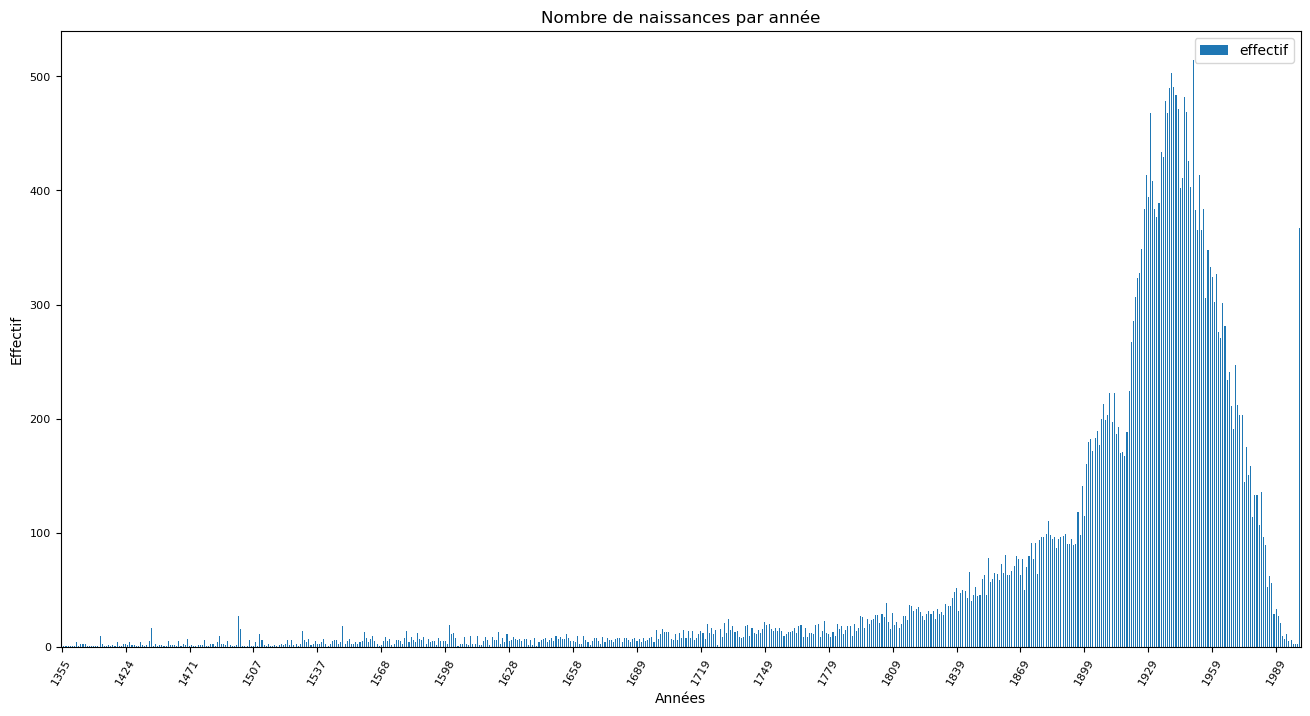

In [35]:
### Représentation graphique des effectifs par année

ax = years_count.plot(x='year', y='effectif', kind='bar',rot=60, fontsize=8, figsize=(16,8))


max_xticks = 20
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Nombre de naissances par année')
plt.show()

## Regrouper les effectifs par périodes de 25 ans

In [36]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_p = df_p[df_p['birthYear'] < 2001].copy(deep=True)

In [37]:
cdf_p.head(3)

,person_uri,person_label,genderUri,birthYear,genCode
id,,,,,
0,http://www.wikidata.org/entity/Q855257,Blasius of Parma,http://www.wikidata.org/entity/Q6581097,1355,M
1,http://www.wikidata.org/entity/Q4121967,Ibn al-Majdi,http://www.wikidata.org/entity/Q6581097,1359,M
2,http://www.wikidata.org/entity/Q9168741,Benedict Makra,http://www.wikidata.org/entity/Q6581097,1360,M


In [38]:
### Année minimale et maximale dans la population
min(cdf_p['birthYear']), max(cdf_p['birthYear'])

(1355, 2000)

### Codage par période de vingt-cinq ans

In [39]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1351, 2002, 25))
l_25[:5],l_25[-5:]

([1351, 1376, 1401, 1426, 1451], [1901, 1926, 1951, 1976, 2001])

In [40]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,person_uri,person_label,genderUri,birthYear,genCode,periodes
id,,,,,,
0,http://www.wikidata.org/entity/Q855257,Blasius of Parma,http://www.wikidata.org/entity/Q6581097,1355,M,1351-1375
1,http://www.wikidata.org/entity/Q4121967,Ibn al-Majdi,http://www.wikidata.org/entity/Q6581097,1359,M,1351-1375
2,http://www.wikidata.org/entity/Q9168741,Benedict Makra,http://www.wikidata.org/entity/Q6581097,1360,M,1351-1375


In [41]:
cdf_p[cdf_p.birthYear == 2000][:3]

,person_uri,person_label,genderUri,birthYear,genCode,periodes
id,,,,,,
33424,http://www.wikidata.org/entity/Q96986,Klaus Fesser,http://www.wikidata.org/entity/Q6581097,2000,M,1976-2000
33425,http://www.wikidata.org/entity/Q166181,R. Scott Dunbar,http://www.wikidata.org/entity/Q6581097,2000,M,1976-2000
33426,http://www.wikidata.org/entity/Q1947401,Mordechai Segev,http://www.wikidata.org/entity/Q6581097,2000,M,1976-2000


In [42]:
### compter les naissances par périodes de 25 ans
cdf_p.groupby(by='periodes').size()

periodes
1351-1375       15
1376-1400       22
1401-1425       25
1426-1450       41
1451-1475       45
1476-1500       82
1501-1525       84
1526-1550      116
1551-1575      127
1576-1600      164
1601-1625      149
1626-1650      151
1651-1675      151
1676-1700      173
1701-1725      282
1726-1750      357
1751-1775      357
1776-1800      433
1801-1825      679
1826-1850     1009
1851-1875     1700
1876-1900     2499
1901-1925     5352
1926-1950    10922
1951-1975     7042
1976-2000     1814
dtype: int64

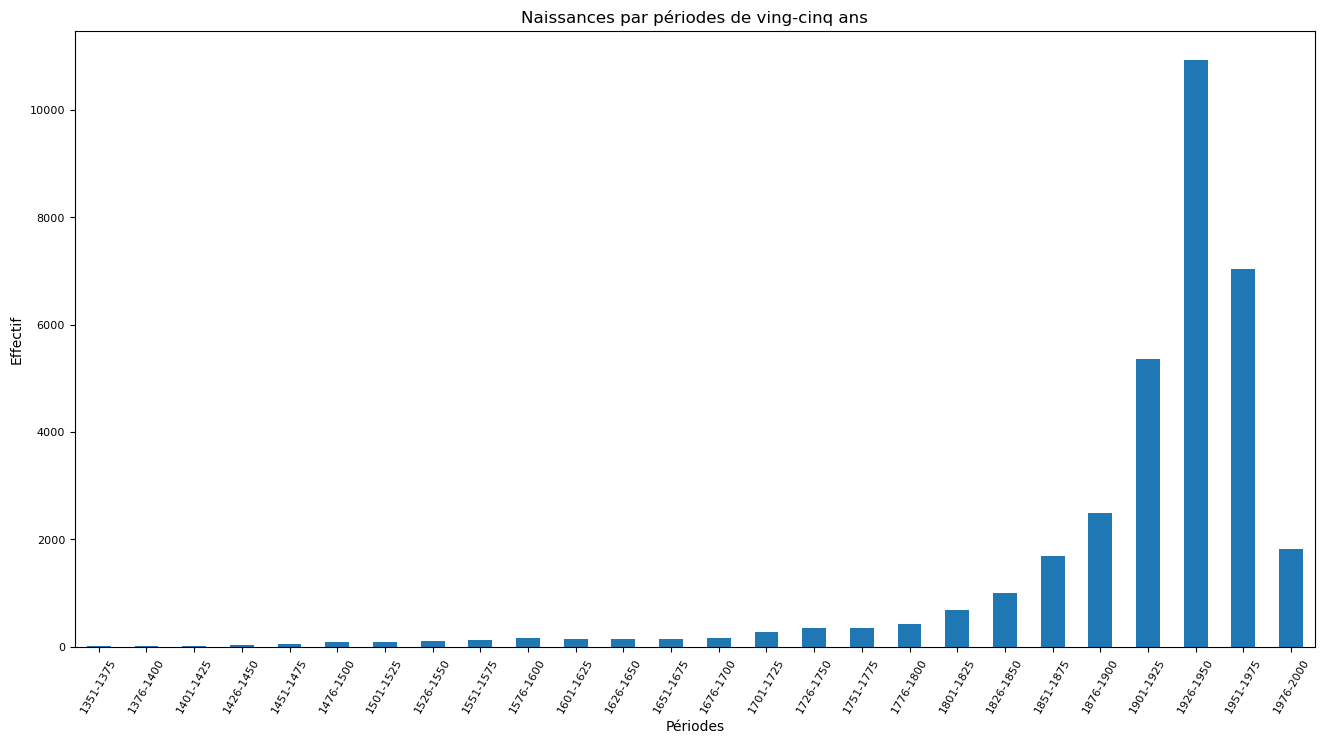

In [43]:
ax = cdf_p.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de ving-cinq ans')
plt.show()

## Ajouter la représentation des genres

In [46]:
### Regrouper et compter avec un fitre sur le genre masculin
gender_m = pd.DataFrame(cdf_p[cdf_p.genCode == 'M'].groupby('periodes').size())
gender_m.columns = ['gen_m']
gender_m.tail()


,gen_m
periodes,
1876-1900,2318
1901-1925,4980
1926-1950,10173
1951-1975,6019
1976-2000,1377


In [47]:
### Regrouper et compter avec un fitre sur le genre féminin
gender_f = pd.DataFrame(cdf_p[cdf_p.genCode == 'F'].groupby('periodes').size())
gender_f.columns = ['gen_f']
gender_f.tail()


,gen_f
periodes,
1876-1900,181
1901-1925,372
1926-1950,746
1951-1975,1018
1976-2000,431


In [48]:
### Fusionner les deux tableaux en utilisant l'index comme clé de jointure
merged = pd.merge(gender_m, gender_f, left_index=True, right_index=True)
merged.tail()

,gen_m,gen_f
periodes,,
1876-1900,2318,181
1901-1925,4980,372
1926-1950,10173,746
1951-1975,6019,1018
1976-2000,1377,431


In [49]:
### Transformer l'index de séquence à chaîne de caractères
# ce qui est indispensable pour l'affichage dans un graphique
merged.index = merged.index.map(str)
merged.tail()

,gen_m,gen_f
periodes,,
1876-1900,2318,181
1901-1925,4980,372
1926-1950,10173,746
1951-1975,6019,1018
1976-2000,1377,431


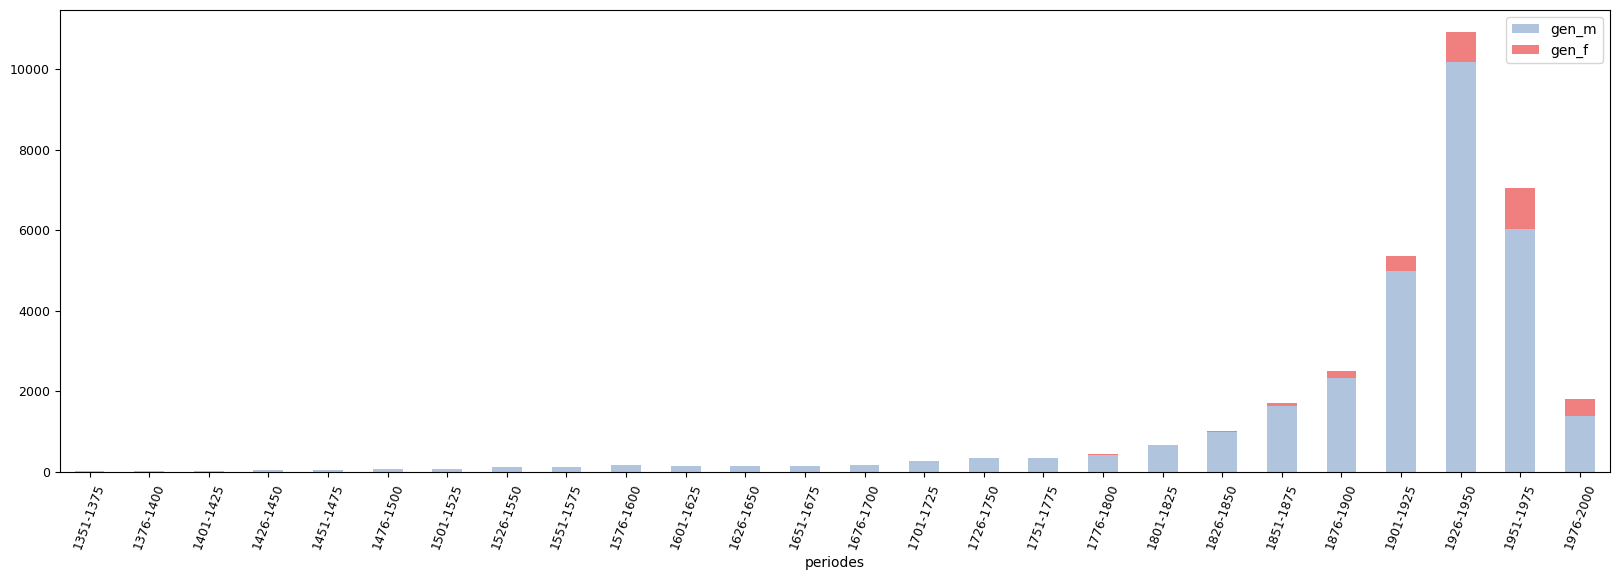

In [50]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,6), color=['LightSteelBlue', 'LightCoral'])
plt.show()

### Codage par période de dix ans

Comme on voit bien dans le graphique précédent qu'il y a deux périodes avec des effectifs radicalements différents, 
on restraint la période analysée à l'époque contemporaine et on affine avec un découpage par périodes de dix ans 

In [51]:
l_10 = list(range(1851, 2002, 10))
l_10[:5],l_10[-5:]

([1851, 1861, 1871, 1881, 1891], [1961, 1971, 1981, 1991, 2001])

In [52]:
### Découpage par décennies
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

cdf_p['per_10'] = pd.cut(cdf_p['birthYear'], l_10, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['per_10'] = cdf_p['per_10'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,person_uri,person_label,genderUri,birthYear,genCode,periodes,per_10
id,,,,,,,
0,http://www.wikidata.org/entity/Q855257,Blasius of Parma,http://www.wikidata.org/entity/Q6581097,1355,M,1351-1375,NaN
1,http://www.wikidata.org/entity/Q4121967,Ibn al-Majdi,http://www.wikidata.org/entity/Q6581097,1359,M,1351-1375,NaN
2,http://www.wikidata.org/entity/Q9168741,Benedict Makra,http://www.wikidata.org/entity/Q6581097,1360,M,1351-1375,NaN


In [53]:
### On regroupe par genre comme ci-dessus
gender_m_10 = pd.DataFrame(cdf_p[(cdf_p.genCode == 'M') & (cdf_p.birthYear > 1850)].groupby('per_10').size())
gender_m_10.columns = ['gen_m']
gender_m_10.tail()


,gen_m
per_10,
1951-1960,3110
1961-1970,2162
1971-1980,1279
1981-1990,487
1991-2000,358


In [54]:
### Idem
gender_f_10 = pd.DataFrame(cdf_p[(cdf_p.genCode == 'F')& (cdf_p.birthYear > 1850)].groupby('per_10').size())
gender_f_10.columns = ['gen_f']
gender_f_10.tail()


,gen_f
per_10,
1951-1960,412
1961-1970,416
1971-1980,346
1981-1990,198
1991-2000,77


In [55]:
merged_10 = pd.merge(gender_m_10, gender_f_10, left_index=True, right_index=True)
merged_10.tail()

,gen_m,gen_f
per_10,,
1951-1960,3110,412
1961-1970,2162,416
1971-1980,1279,346
1981-1990,487,198
1991-2000,358,77


In [56]:
### On transforme le type de valeur de l'index
# et on ajoute une colonne avec le total
merged_10.index = merged_10.index.map(str)
merged_10['tot']=merged_10['gen_m']+merged_10['gen_f']
merged_10.tail()

,gen_m,gen_f,tot
per_10,,,
1951-1960,3110,412,3522
1961-1970,2162,416,2578
1971-1980,1279,346,1625
1981-1990,487,198,685
1991-2000,358,77,435


In [57]:
### On prépare les valeurs pour l'affichage des fréquences (proportion par rapport au total)

# liste qui contient toutes les valeurs à la suite
m_f = merged_10.gen_m.to_list()+merged_10.gen_f.to_list()

# liste d'égale longueur que la précédente qui contient 
# les valeurs de l'index, i.e. les périodes
tot = merged_10.tot.to_list()*2

# liste qui contient les valeurs des fréquences
lp = [round(v/t, 2) for v,t in zip(m_f, tot)]
lp[:3]

[0.98, 0.95, 0.96]

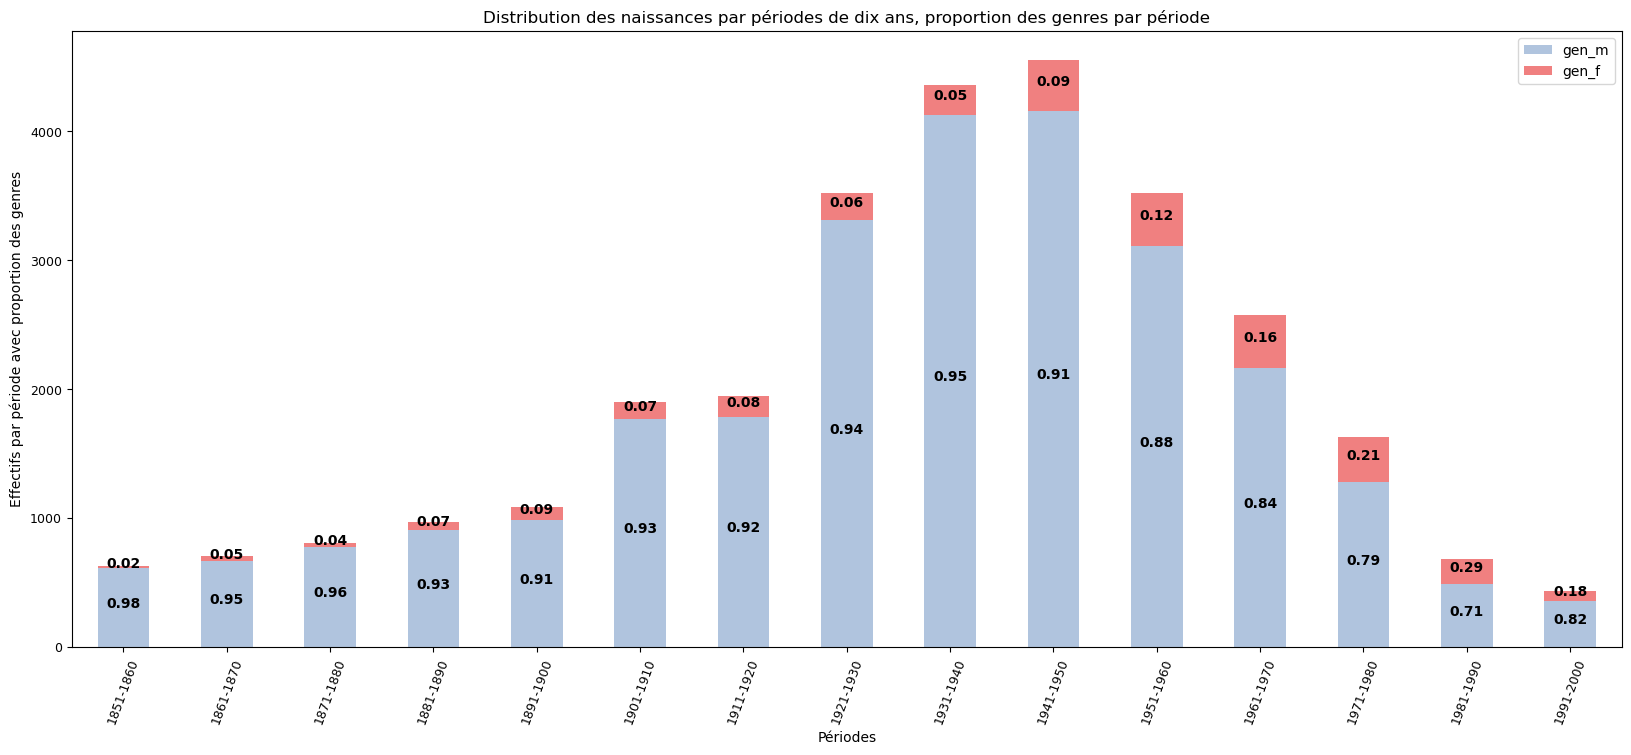

In [58]:
### Graphique avec la distribution par période et genre (M,F)
# Noter que les effectifs du genre 'Autres' étant très faibles,
# on ne les analyse pas de manière sérielle mais on peut les analyser qualitatiement

ax = merged_10.plot.bar(stacked=True, y=['gen_m', 'gen_f'], \
                        rot=70, fontsize=9, figsize=(20,8), color=['LightSteelBlue', 'LightCoral'])


### https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/


## On ajoute une étiquette concernant la valeur de fréquence
# à chaque rectangle dans le graphe, en utilisant la list 'lp' préparée précédemment
# Il y a autant de triangles que les valeurs d'index x le nombre de variables

for bar,v in zip(ax.patches,lp): 

    ax.text(
      # Met les étiquette aux centre des rectangles
      bar.get_x() + bar.get_width() / 2,
        
      # Ajoute les coordonnées verticales
      bar.get_height()/2 + bar.get_y(), 
      
      # Ajoute les valeurs
      v,

      # centre et met du style aux étiquettes
      ha='center',
      color='black',
      weight='bold',
      size=10
  )

plt.ylabel('Effectifs par période avec proportion des genres')
plt.xlabel('Périodes')
plt.title('Distribution des naissances par périodes de dix ans, proportion des genres par période')

## On peut enregistrer l'image dans un fichier (noter le dossier créé préalablement)
# qu'on pourra ensuite introduire dans un travail et commenter

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/naissances_distribution_10ans_genre.jpg', bbox_inches='tight',
                       pad_inches=0.2)
plt.show()